In [3]:
import sys
import numpy
import matplotlib
import keras
import skimage
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os
print('Python: {}'.format(sys.version))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
# python magic function, displays pyplot figures in the notebook
%matplotlib inline

Python: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
NumPy: 1.21.5
Matplotlib: 3.5.1
Scikit-Image: 0.19.2
Keras: 2.8.0
OpenCV: 4.6.0


In [4]:
# prepare degraded images by  and 2x scaling

def prepare_degraded_images(image_path, scaling_factor):
    
    # iterate for each files in the directory
    print('Creating degraded images:\n')
    for file in os.listdir(image_path):
        
        # open the file
        old_img = cv2.imread(image_path + '/' + file)
        
        # find old and new image dimensions
        height, width, _ = old_img.shape
        new_height = int(height / scaling_factor)
        new_width = int(width / scaling_factor)
        
        # resize the image - down
        cropped_img = cv2.resize(old_img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        degraded_img = cv2.resize(cropped_img, (width, height), interpolation = cv2.INTER_LINEAR)
        
        #print the file name
        print('{} created'.format(file))
        # save the image
        cv2.imwrite('degraded/{}'.format(file), degraded_img)
        
def crop(image, scale_factor):
    temp_size = image.shape
    size = temp_size[0:2]
    size = size - np.mod(size, scale_factor)
    #resizing pixcel metrix
    image = image[0:size[0], 1:size[1]]
    return image

#remove borders
def shave(image, border):
    img = image[border: -border, border: -border]
    return img

# create the super-resolution model
def create_model():
    
    # define model type
    model = Sequential()
    
    # add model layers
    #Layer 1
    model.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    #Layer 2
    model.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    #Layer 3
    model.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model
# mean squared error (MSE) function definition
def mse(target_image, original_image):
    # sum of the squared difference
    squraed_diff=(target_image.astype('float') - original_image.astype('float')) ** 2
    val = np.sum(squraed_diff)
    
    #scale the value according to picture dimension
    val /= float(target_image.shape[0] * target_image.shape[1])
    
    return val

# Peak Signal to Noise Ratio(PSNR) function definition
def psnr(target_image, original_image):
         
    # RGB image
    target_data = target_image.astype(float)
    original_data = original_image.astype(float)

    #pixcel difference metrics
    diff = original_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function that combines all three image quality metrics
def compare_images(target_image, original_image):
    performence_val = []
    performence_val.append(psnr(target_image, original_image))
    performence_val.append(mse(target_image, original_image))
    performence_val.append(ssim(target_image, original_image, multichannel =True))
    
    return performence_val

prepare_degraded_images('original/', 2)

Creating degraded images:

baboon.bmp created
baby_GT.bmp created
barbara.bmp created
bird_GT.bmp created
butterfly.bmp created
comic.bmp created
face.bmp created
flowers.bmp created
foreman.bmp created
head_GT.bmp created
lenna.bmp created
monarch.bmp created
pepper.bmp created
ppt3.bmp created
saurabh.bmp created
woman_GT.bmp created
zebra.bmp created


Text(0.5, 1.0, 'Degraded')

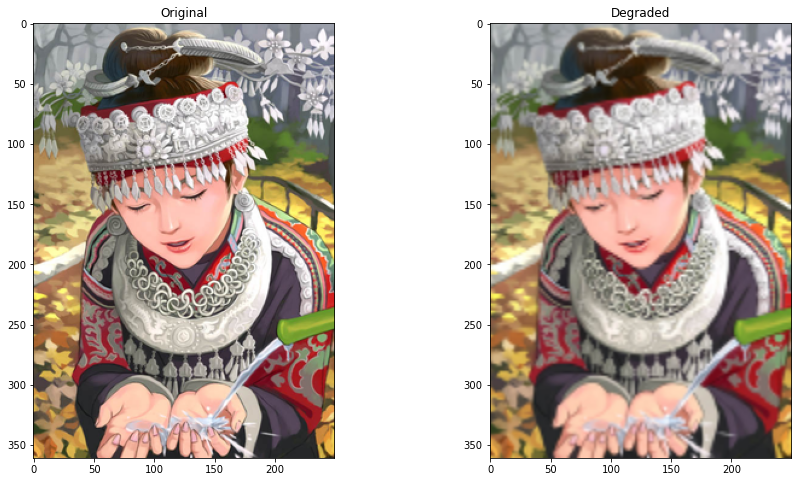

In [12]:
degraded=cv2.imread('degraded/comic.bmp')
original=cv2.imread('original/comic.bmp')
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
# print(degraded)

In [6]:
# check the degraded images using the image quality metrics
# print('Image file name\t\tMSE\t\tPSNR\t\tSSIM')
for file in os.listdir('degraded/'):
    
    # open target and reference images
    target_image = cv2.imread('degraded/{}'.format(file))
    original_image = cv2.imread('original/{}'.format(file))
    
    # calculate score
    performance_metrix = compare_images(target_image, original_image)
    # print all three scores  
    print('Image file name:{}\tMSE:{}\tPSNR:{}\tSSIM:{}\n'.format(file, performance_metrix[0], performance_metrix[1], performance_metrix[2]))

C:\Users\bhara\AppData\Local\Temp\ipykernel_14516\3249745294.py:96: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  performence_val.append(ssim(target_image, original_image, multichannel =True))


Image file name:baboon.bmp	MSE:22.157084083442548	PSNR:1187.1161333333334	SSIM:0.629277587900277

Image file name:baby_GT.bmp	MSE:34.37180640966199	PSNR:71.28874588012695	SSIM:0.9356987872724932

Image file name:barbara.bmp	MSE:25.906629837568126	PSNR:500.65508535879627	SSIM:0.8098632646406401

Image file name:bird_GT.bmp	MSE:32.896644728720005	PSNR:100.12375819830247	SSIM:0.9533644866026473

Image file name:butterfly.bmp	MSE:24.782076560337416	PSNR:648.6254119873047	SSIM:0.8791344763843051

Image file name:comic.bmp	MSE:23.799861502225532	PSNR:813.2338836565096	SSIM:0.8347335416398209

Image file name:face.bmp	MSE:30.99220650287191	PSNR:155.23189718546524	SSIM:0.8008439492289884

Image file name:flowers.bmp	MSE:27.454504805386147	PSNR:350.55093922651935	SSIM:0.8697286286974628

Image file name:foreman.bmp	MSE:30.14456532664372	PSNR:188.6883483270202	SSIM:0.933268417388899

Image file name:head_GT.bmp	MSE:31.020502848237534	PSNR:154.2237755102041	SSIM:0.8011121330733371

Image file nam

In [7]:
# prediction function
def predict(image_path):
    
    # load the isr(image super resolution) model with weights
    isr = create_model()
    isr.load_weights('node_weight.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    original = cv2.imread('original/{}'.format(file))
    
    # preprocess the image with crop
    original = crop(original, 3)
    degraded = crop(degraded, 3)
    
    # convert the image to YCrCb color space because our model trained on Y channel
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # image slice and normalize  
    X = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    X[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with isr model
    pre = isr.predict(X, batch_size=1)
    
    # process output
    pre *= 255
    pre[pre[:] > 255] = 255 #if pixcel value is greater than 255
    pre[pre[:] < 0] = 0 #if pixcel value is less than 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from original and degraged image
    original = shave(original.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # quality metrix calculation
    perfomance_vals = []
    perfomance_vals.append(compare_images(degraded, original))
    perfomance_vals.append(compare_images(output, original))
    
    # return images and performance_vals
    return original, degraded, output, perfomance_vals

C:\Users\bhara\AppData\Local\Temp\ipykernel_14516\3249745294.py:96: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  performence_val.append(ssim(target_image, original_image, multichannel =True))


Degraded Image: 
PSNR: 23.635798521218994	MSE: 844.5429938632378	SSIM: 0.8295735523314516

Reconstructed Image: 
PSNR: 25.882429134012234	MSE: 503.4527323202805	SSIM: 0.8994648135506398



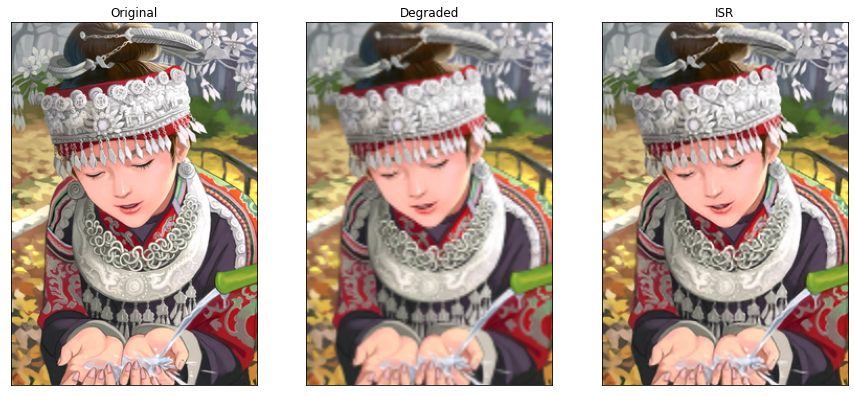

In [11]:
original, degraded, output, perfomance_vals = predict('degraded/comic.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\tMSE: {}\tSSIM: {}\n'.format(perfomance_vals[0][0], perfomance_vals[0][1], perfomance_vals[0][2]))
print('Reconstructed Image: \nPSNR: {}\tMSE: {}\tSSIM: {}\n'.format(perfomance_vals[1][0], perfomance_vals[1][1], perfomance_vals[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('ISR')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

C:\Users\bhara\AppData\Local\Temp\ipykernel_14516\3249745294.py:96: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  performence_val.append(ssim(target_image, original_image, multichannel =True))


Degraded Image: 
PSNR: 23.635798521218994	MSE: 844.5429938632378	SSIM: 0.8295735523314516

Reconstructed Image: 
PSNR: 25.882429134012234	MSE: 503.4527323202805	SSIM: 0.8994648135506398



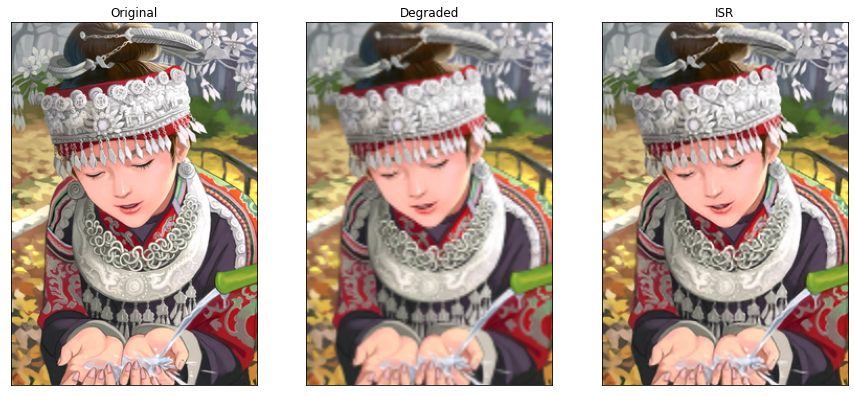

In [9]:
original, degraded, output, perfomance_vals = predict('degraded/comic.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\tMSE: {}\tSSIM: {}\n'.format(perfomance_vals[0][0], perfomance_vals[0][1], perfomance_vals[0][2]))
print('Reconstructed Image: \nPSNR: {}\tMSE: {}\tSSIM: {}\n'.format(perfomance_vals[1][0], perfomance_vals[1][1], perfomance_vals[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('ISR')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

Creating Result images:



C:\Users\bhara\AppData\Local\Temp\ipykernel_14516\3249745294.py:96: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  performence_val.append(ssim(target_image, original_image, multichannel =True))


baboon.bmp restored
baby_GT.bmp restored
barbara.bmp restored
bird_GT.bmp restored
butterfly.bmp restored
comic.bmp restored
face.bmp restored
flowers.bmp restored
foreman.bmp restored
head_GT.bmp restored
lenna.bmp restored
monarch.bmp restored
pepper.bmp restored
ppt3.bmp restored
saurabh.bmp restored
woman_GT.bmp restored
zebra.bmp restored


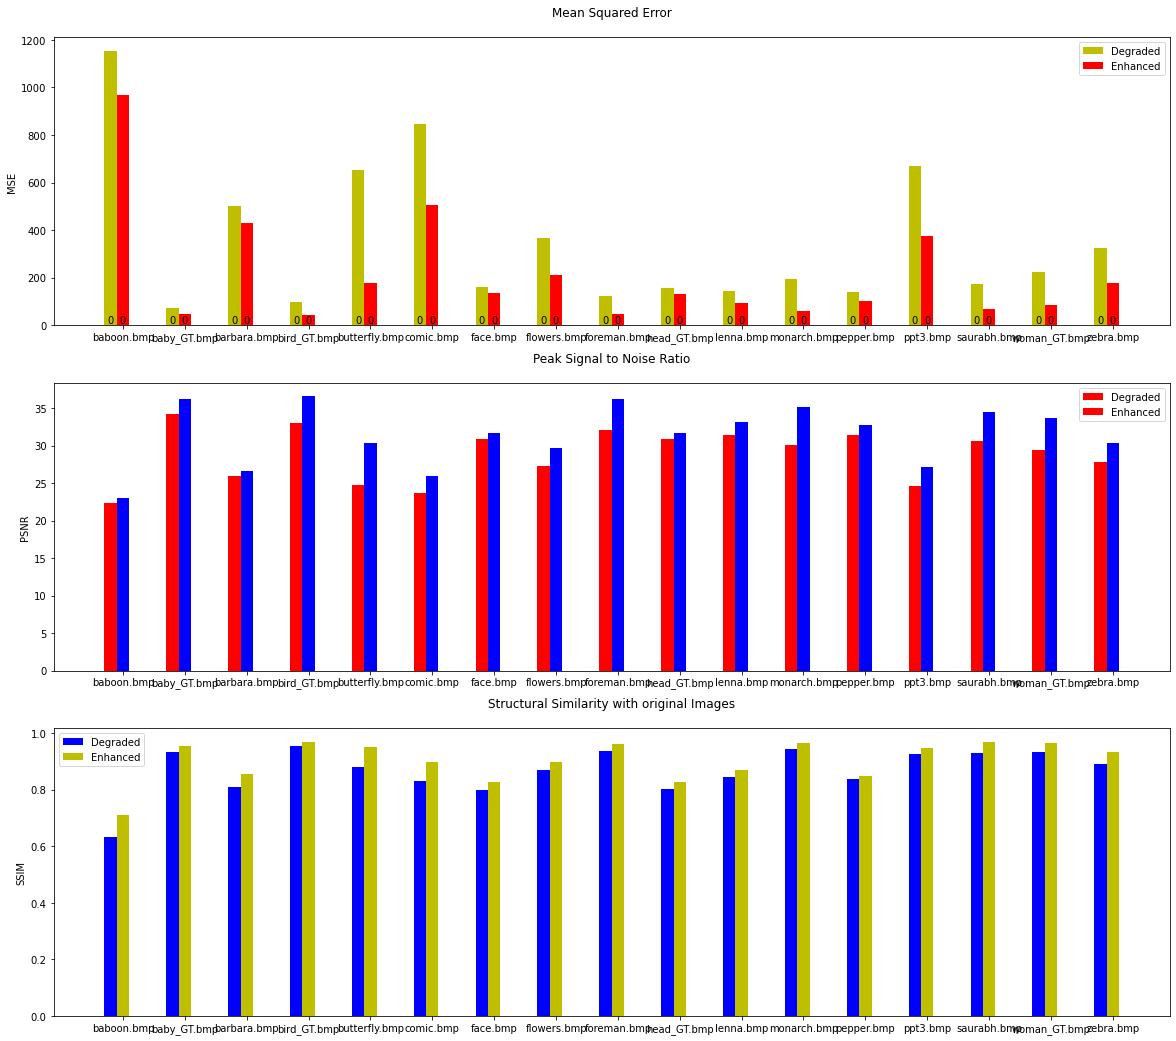

In [10]:
names=()
N=0
yvals_MSE=[]
yvals_PSNR=[]
yvals_SSIM=[]
zvals_MSE=[]
zvals_PSNR=[]
zvals_SSIM=[]

print('Creating Result images:\n')
for file in os.listdir('degraded'):
    
    # perform super-resolution
    original, degraded, output, perfomance_vals = predict('degraded/{}'.format(file))
    
    names=names + (file,)
    yvals_MSE.append(perfomance_vals[0][1])
    zvals_MSE.append(perfomance_vals[1][1])
    
    yvals_PSNR.append(perfomance_vals[0][0])
    zvals_PSNR.append(perfomance_vals[1][0])
    
    yvals_SSIM.append(perfomance_vals[0][2])
    zvals_SSIM.append(perfomance_vals[1][2])
    
    N=N+1
        
    # display images as subplots
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(perfomance_vals[0][0], perfomance_vals[0][1], perfomance_vals[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('ISP')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(perfomance_vals[1][0], perfomance_vals[1][1], perfomance_vals[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('{} restored'.format(file))
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

#Display comparitive bar graph of performance metrics
ind = np.arange(N)  # the x locations for the groups
width = 0.2       # the width of the bars

fig1,ax = plt.subplots(3, 1, figsize=(20, 18))

rects1 = ax[0].bar(ind, yvals_MSE, width, color='y')
rects2 = ax[0].bar(ind+width, zvals_MSE, width, color='r')


ax[0].set_ylabel('MSE')
ax[0].set_xticks(ind+width)
ax[0].set_xticklabels( names )
ax[0].legend( (rects1[0], rects2[0]), ('Degraded', 'Enhanced') )
ax[0].set_title('Mean Squared Error\n')


rects1 = ax[1].bar(ind, yvals_PSNR, width, color='r')
rects2 = ax[1].bar(ind+width, zvals_PSNR, width, color='b')

ax[1].set_ylabel('PSNR')
ax[1].set_xticks(ind+width)
ax[1].set_xticklabels( names )
ax[1].legend( (rects1[0], rects1[0]), ('Degraded', 'Enhanced') )
ax[1].set_title('Peak Signal to Noise Ratio\n')



rects1 = ax[2].bar(ind, yvals_SSIM, width, color='b')
rects2 = ax[2].bar(ind+width, zvals_SSIM, width, color='y')

ax[2].set_ylabel('SSIM')
ax[2].set_xticks(ind+width)
ax[2].set_xticklabels( names )
ax[2].legend( (rects1[0], rects2[0]), ('Degraded', 'Enhanced') )
ax[2].set_title('Structural Similarity with original Images\n')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax[0].text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.show()